In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
tf.config.list_physical_devices('GPU')
import urllib3
urllib3.disable_warnings()

In [2]:

(ds_train, ds_test), ds_info = tfds.load(
   'cifar10',
   split=['train', 'test'],
   shuffle_files=True,
   with_info=True,
)

print(ds_info.features)
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [3]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
       normalize_and_resize_img,
       num_parallel_calls=1)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


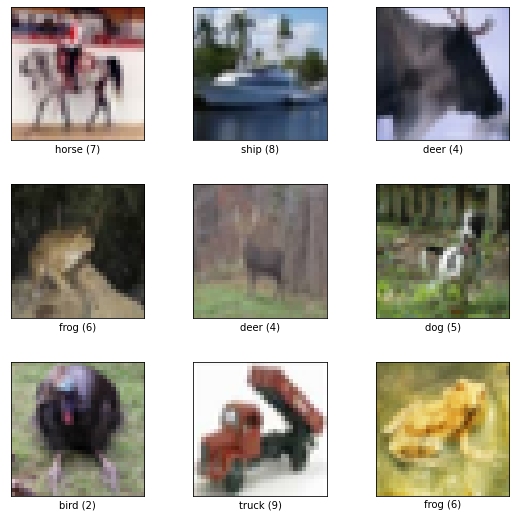

In [4]:
print(ds_info.features["label"].num_classes)
print(ds_info.features["label"].names)
fig = tfds.show_examples(ds_train, ds_info)

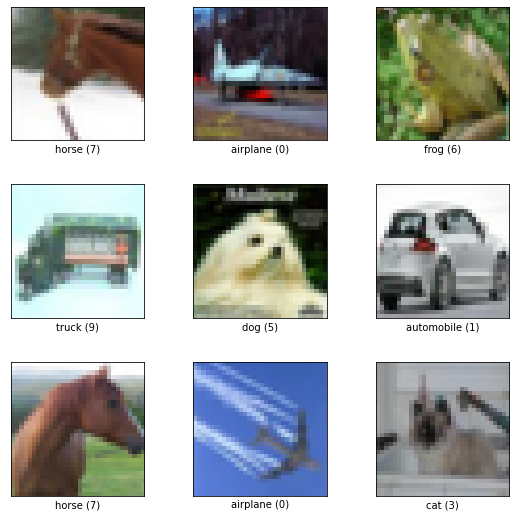

In [5]:
fig = tfds.show_examples(ds_test, ds_info)

## VGG model

In [6]:
def build_vgg_block(input_layer,
                   num_cnn=3,
                   channel=64,
                   block_num=1,
                  ):
    # 입력 레이어
    x = input_layer
    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
           filters=channel,
           kernel_size=(3,3),
           activation='relu',
           kernel_initializer='he_normal',
           padding='same',
           name=f'block{block_num}_conv{cnn_num}')(x)
        x = keras.layers.MaxPooling2D(
           pool_size=(2, 2),
           strides=2,
           name=f'block{block_num}_pooling')(x)
        return x

def build_vgg(input_shape=(32,32,3),
             num_cnn_list=[2,2,3,3,3],
             channel_list=[64,128,256,512,512],
             num_classes=10):
  
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.

    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
           output,
           num_cnn=num_cnn,
           channel=channel,
           block_num=i
        )

    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

    model = keras.Model(
       inputs=input_layer,
       outputs=output
    )
    return model

In [7]:
vgg_16 = build_vgg()
vgg_16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0         
_________________________________________________________________
block2_conv0 (Conv2D)        (None, 8, 8, 256)         295168    
_________________________________________________________________
block2_pooling (MaxPooling2D (None, 4, 4, 256)         0     

In [8]:
vgg_19 = build_vgg(
   num_cnn_list=[2,2,4,4,4],
   channel_list=[64,128,256,512,512]
)
vgg_19.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0         
_________________________________________________________________
block2_conv0 (Conv2D)        (None, 8, 8, 256)         295168    
_________________________________________________________________
block2_pooling (MaxPooling2D (None, 4, 4, 256)         0   

In [9]:
BATCH_SIZE = 256
EPOCH = 20
(ds_train, ds_test), ds_info = tfds.load(
   'cifar10',
   split=['train', 'test'],
   as_supervised=True,
   shuffle_files=True,
   with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

vgg_16.compile(
   loss='sparse_categorical_crossentropy',
   optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
   metrics=['accuracy'],
)

history_16 = vgg_16.fit(
   ds_train,
   steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
   validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
   epochs=EPOCH,
   validation_data=ds_test,
   verbose=1,
   use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 7s 38ms/step - loss: 2.0998 - accuracy: 0.2364 - val_loss: 1.9660 - val_accuracy: 0.3003
Epoch 2/20
195/195 [==============================] - 7s 36ms/step - loss: 1.9144 - accuracy: 0.3140 - val_loss: 1.8473 - val_accuracy: 0.3508
Epoch 3/20
195/195 [==============================] - 29s 147ms/step - loss: 1.8139 - accuracy: 0.3553 - val_loss: 1.7468 - val_accuracy: 0.3736
Epoch 4/20
195/195 [==============================] - 7s 36ms/step - loss: 1.7333 - accuracy: 0.3876 - val_loss: 1.7038 - val_accuracy: 0.3991
Epoch 5/20
195/195 [==============================] - 7s 36ms/step - loss: 1.6761 - accuracy: 0.3994 - val_loss: 1.6042 - val_accuracy: 0.4317
Epoch 6/20
195/195 [==============================] - 7s 36ms/step - loss: 1.6204 - accuracy: 0.4208 - val_loss: 1.6876 - val_accuracy: 0.3877
Epoch 7/20
195/195 [==============================] - 7s 37ms/step - loss: 1.5744 - accuracy: 0.4392 - val_loss: 1.5556 - val_accuracy: 0.44

In [10]:
vgg_19.compile(
   loss='sparse_categorical_crossentropy',
   optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
   metrics=['accuracy'],
)

history_19 = vgg_19.fit(
   ds_train,
   steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
   validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
   epochs=EPOCH,
   validation_data=ds_test,
   verbose=1,
   use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 7s 37ms/step - loss: 2.0542 - accuracy: 0.2580 - val_loss: 1.9055 - val_accuracy: 0.3217
Epoch 2/20
195/195 [==============================] - 7s 37ms/step - loss: 1.8464 - accuracy: 0.3453 - val_loss: 1.7697 - val_accuracy: 0.3738
Epoch 3/20
195/195 [==============================] - 7s 37ms/step - loss: 1.7480 - accuracy: 0.3739 - val_loss: 1.6925 - val_accuracy: 0.4054
Epoch 4/20
195/195 [==============================] - 7s 37ms/step - loss: 1.6665 - accuracy: 0.4059 - val_loss: 1.6532 - val_accuracy: 0.4032
Epoch 5/20
195/195 [==============================] - 7s 37ms/step - loss: 1.6169 - accuracy: 0.4181 - val_loss: 1.5978 - val_accuracy: 0.4317
Epoch 6/20
195/195 [==============================] - 7s 37ms/step - loss: 1.5649 - accuracy: 0.4404 - val_loss: 1.5565 - val_accuracy: 0.4539
Epoch 7/20
195/195 [==============================] - 7s 37ms/step - loss: 1.5375 - accuracy: 0.4483 - val_loss: 1.4927 - val_accuracy: 0.4611

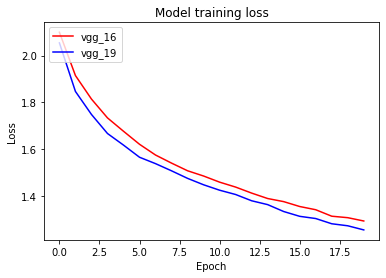

In [11]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

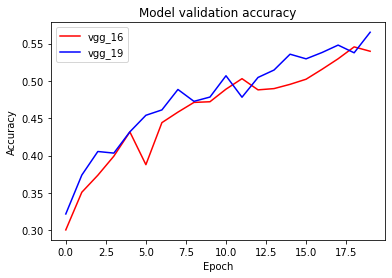

In [12]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

## ResNet model

In [2]:
def res_conv(in_layer,k,s,o,is_relu=True):
    in_layer = keras.layers.Conv2D(
        filters=o,
        kernel_size=(k,k),
        strides=(s,s),
        kernel_initializer='he_normal',
        padding='same')(in_layer)
    in_layer = keras.layers.BatchNormalization()(in_layer)
    if is_relu:
        in_layer = keras.layers.Activation('relu')(in_layer)
    return in_layer

def res_block(x,channel,is_first=False,is_down=True,is_bottle=False,is_plain=False):
    if is_bottle:
        k_list = [1,3,1]
        o_list = [channel,channel,channel*4]
    else:
        k_list = [3,3]
        o_list = [channel,channel]
    if is_first:
        if is_down:
            in_layer = res_conv(x,k_list[0],2,o_list[0])
            if not is_plain:
                x = res_conv(x,1,2,o_list[-1],is_relu=False)
        else:
            in_layer = res_conv(x,k_list[0],1,o_list[0])
            if not is_plain:
                x = res_conv(x,1,1,o_list[-1],is_relu=False)

        for i in range(1,len(k_list)):
            if i is not len(k_list)-1:
                in_layer = res_conv(in_layer,k_list[i],1,o_list[i])
            else:
                in_layer = res_conv(in_layer,k_list[i],1,o_list[i],is_relu=False)

    else:
        in_layer = x
        for i in range(len(k_list)):
            if i is not len(k_list)-1:
                in_layer = res_conv(in_layer,k_list[i],1,o_list[i])
            else:
                in_layer = res_conv(in_layer,k_list[i],1,o_list[i],is_relu=False)
    if not is_plain:
        return x+in_layer
    else:
        return in_layer

def build_resnet(input_shape=(32,32,3),
                channel_list =[64,128,256,512], 
                num_classes=10,
                is_bottle=False,
                is_plain=False):
    num_iter_list =[3,4,6,3]
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    output = res_conv(input_layer,7,2,64)
    output = keras.layers.MaxPooling2D(pool_size = (2,2))(output)
    
    for i in range(len(num_iter_list)):
        if i==0:
            for j in range(num_iter_list[i]):
                if j==0:
                    output = res_block(output,channel_list[i],is_first=True,is_down=False,is_bottle=is_bottle,is_plain=is_plain)
                else:
                    output = res_block(output,channel_list[i],is_first=False,is_down=False,is_bottle=is_bottle,is_plain=is_plain)
                output = keras.layers.Activation('relu')(output)
        else:
            for j in range(num_iter_list[i]):
                if j==0:
                    output = res_block(output,channel_list[i],is_first=True,is_bottle=is_bottle,is_plain=is_plain)
                else:
                    output = res_block(output,channel_list[i],is_bottle=is_bottle,is_plain=is_plain)
                output = keras.layers.Activation('relu')(output)
    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

    
    model = keras.Model(
       inputs=input_layer,
       outputs=output
    )
    
    return model

resnet34 = build_resnet()
resnet34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [3]:
resnet50 = build_resnet(is_bottle=True)
resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 16, 16, 64)   256         conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_37[0][0]     
____________________________________________________________________________________________

In [4]:
plain34 = build_resnet(is_plain=True)
plain34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_90 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_82 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_91 (Batc (None, 8, 8, 64)          256 

In [5]:
plain50 = build_resnet(is_bottle=True,is_plain=True)
plain50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_123 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
activation_115 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 8, 8, 64)          4160      
_________________________________________________________________
batch_normalization_124 (Bat (None, 8, 8, 64)          256 

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
   'cats_vs_dogs',
   split=['train[:80%]', 'train[80%:]'],
   shuffle_files=True,
   with_info=True,
)

In [7]:
print(ds_info.features)
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})
tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


2
['cat', 'dog']


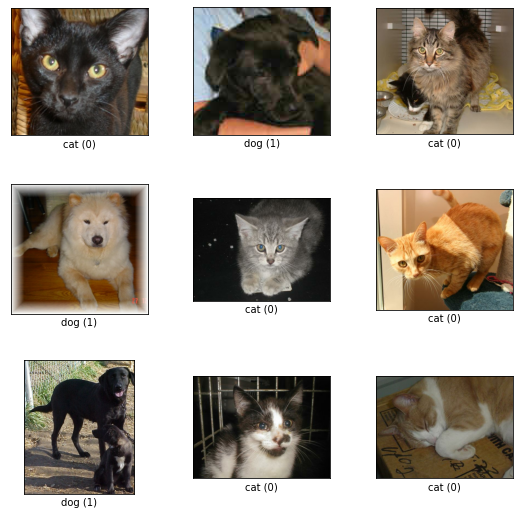

In [8]:
print(ds_info.features["label"].num_classes)
print(ds_info.features["label"].names)

fig = tfds.show_examples(ds_train, ds_info)

In [9]:
def normalize_and_resize_img(info):
    """Normalizes images: `uint8` -> `float32`."""
    image = info['image']
    label = info['label']
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
       normalize_and_resize_img,
       num_parallel_calls=1)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
BATCH_SIZE = 16
EPOCH = 10

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

data_num = ds_info.splits['train'].num_examples
train_num = int(data_num*0.8+0.5)
test_num = data_num-train_num


resnet34 = build_resnet(input_shape=(224,224,3), num_classes= ds_info.features["label"].num_classes)
plain34 = build_resnet(input_shape=(224,224,3),num_classes= ds_info.features["label"].num_classes,is_plain=True)

resnet34.compile(
   loss='sparse_categorical_crossentropy',
   optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
   metrics=['accuracy'],
)

history_res34 = resnet34.fit(
   ds_train,
   steps_per_epoch=train_num//BATCH_SIZE,
   validation_steps=test_num//BATCH_SIZE,
   epochs=EPOCH,
   validation_data=ds_test,
   verbose=1,
   use_multiprocessing=True,
)

plain34.compile(
   loss='sparse_categorical_crossentropy',
   optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
   metrics=['accuracy'],
)

history_plain34 = plain34.fit(
   ds_train,
   steps_per_epoch=train_num//BATCH_SIZE,
   validation_steps=test_num//BATCH_SIZE,
   epochs=EPOCH,
   validation_data=ds_test,
   verbose=1,
   use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 96s 82ms/step - loss: 0.6753 - accuracy: 0.6154 - val_loss: 0.6249 - val_accuracy: 0.6554
Epoch 2/10
1163/1163 [==============================] - 126s 108ms/step - loss: 0.6016 - accuracy: 0.6786 - val_loss: 0.5740 - val_accuracy: 0.7037
Epoch 3/10
1163/1163 [==============================] - 109s 94ms/step - loss: 0.5536 - accuracy: 0.7177 - val_loss: 0.5434 - val_accuracy: 0.7403
Epoch 4/10
1163/1163 [==============================] - 96s 83ms/step - loss: 0.5066 - accuracy: 0.7519 - val_loss: 0.5878 - val_accuracy: 0.6887
Epoch 5/10
1163/1163 [==============================] - 96s 83ms/step - loss: 0.4564 - accuracy: 0.7846 - val_loss: 0.5693 - val_accuracy: 0.7252
Epoch 6/10
1163/1163 [==============================] - 96s 83ms/step - loss: 0.4028 - accuracy: 0.8166 - val_loss: 0.8177 - val_accuracy: 0.6897
Epoch 7/10
1163/1163 [==============================] - 96s 83ms/step - loss: 0.3454 - accuracy: 0.8475 - val_loss: 0.561

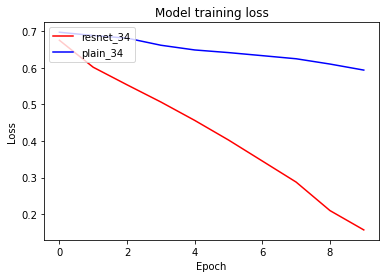

In [11]:
import matplotlib.pyplot as plt

plt.plot(history_res34.history['loss'], 'r')
plt.plot(history_plain34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

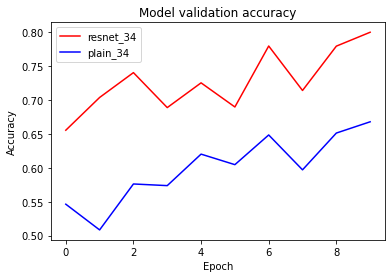

In [12]:
plt.plot(history_res34.history['val_accuracy'], 'r')
plt.plot(history_plain34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')l
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

In [13]:
resnet50 = build_resnet(input_shape=(224,224,3), num_classes= ds_info.features["label"].num_classes,is_bottle=True)
plain50 = build_resnet(input_shape=(224,224,3),num_classes= ds_info.features["label"].num_classes,is_plain=True,is_bottle=True)

resnet50.compile(
   loss='sparse_categorical_crossentropy',
   optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
   metrics=['accuracy'],
)

history_res50 = resnet50.fit(
   ds_train,
   steps_per_epoch=train_num//BATCH_SIZE,
   validation_steps=test_num//BATCH_SIZE,
   epochs=EPOCH,
   validation_data=ds_test,
   verbose=1,
   use_multiprocessing=True,
)

plain50.compile(
   loss='sparse_categorical_crossentropy',
   optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
   metrics=['accuracy'],
)

history_plain50 = plain50.fit(
   ds_train,
   steps_per_epoch=train_num//BATCH_SIZE,
   validation_steps=test_num//BATCH_SIZE,
   epochs=EPOCH,
   validation_data=ds_test,
   verbose=1,
   use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 225s 193ms/step - loss: 0.6978 - accuracy: 0.5824 - val_loss: 0.6558 - val_accuracy: 0.6305
Epoch 2/10
1163/1163 [==============================] - 157s 135ms/step - loss: 0.6785 - accuracy: 0.6052 - val_loss: 1.1911 - val_accuracy: 0.4996
Epoch 3/10
1163/1163 [==============================] - 157s 135ms/step - loss: 0.6696 - accuracy: 0.6179 - val_loss: 0.8117 - val_accuracy: 0.5610
Epoch 4/10
1163/1163 [==============================] - 157s 135ms/step - loss: 0.6581 - accuracy: 0.6284 - val_loss: 0.6516 - val_accuracy: 0.6383
Epoch 5/10
1163/1163 [==============================] - 157s 135ms/step - loss: 0.6520 - accuracy: 0.6338 - val_loss: 0.7331 - val_accuracy: 0.5927
Epoch 6/10
1163/1163 [==============================] - 157s 135ms/step - loss: 0.6492 - accuracy: 0.6359 - val_loss: 0.6985 - val_accuracy: 0.6542
Epoch 7/10
1163/1163 [==============================] - 157s 135ms/step - loss: 0.6438 - accuracy: 0.6426 - val_

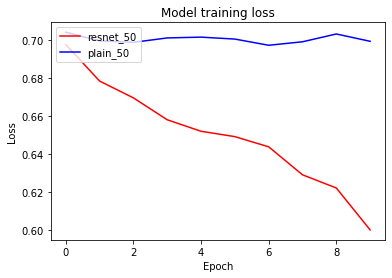

In [15]:
import matplotlib.pyplot as plt

plt.plot(history_res50.history['loss'], 'r')
plt.plot(history_plain50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

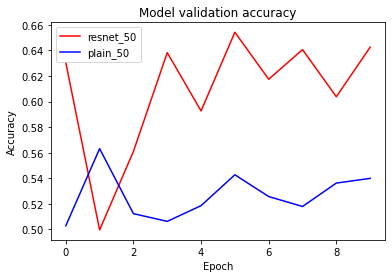

In [16]:
plt.plot(history_res50.history['val_accuracy'], 'r')
plt.plot(history_plain50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

#### 두 결과에서 resnet이 수렴속도, 정확도 모두 우위를 보인다. layer 34가 train과 validation loss의 차이가 더 커서 layer 50이 더 안정적으로 보이기는 하지만 해해당 실험은 epoch를 더 늘려야 확실할 것 같다.